# NEI Prototyping
Tests and prototyping for a non-equilibrium ionization calculation in synthesizAR. 

In [33]:
import os
import sys
import subprocess

import numpy as np
import astropy.units as u
from scipy.interpolate import splev,splrep,interp1d
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
import numba
import h5py
import ChiantiPy.core as ch
import ChiantiPy.tools as ch_tools

import synthesizAR
from synthesizAR.util import InputHandler,OutputHandler

%matplotlib inline

We'll calculate the non-equilibrium ion populations using the equation,

$$
\frac{\partial Y_i}{\partial t} + \frac{\partial Y_iv}{\partial s} = n(I_{i-1}Y_{i-1} + R_{i}Y_{i+1} - I_iY_i - R_{i-1}Y_{i}),
$$

though in our "0D" cases we can drop the spatial gradient terms such that,

$$
\frac{\partial Y_i}{\partial t} = n(I_{i-1}Y_{i-1} + R_{i}Y_{i+1} - I_iY_i - R_{i-1}Y_{i}),
$$

where:
* $Y$ is the element
* $i$ is the ionization state
* $I$ is the ionization rate
* $R$ is the recombination rate

The density, ionization rate, and recombination rates are known ahead of time (from the simulation and CHIANTI, respectively).

## Test $T$ and $n$ profiles

In [2]:
delta_t = 1e-2
total_time = 30.0
time = np.arange(0,total_time+delta_t,delta_t)
tau_increase_T,tau_decrease_T,tau_flat_T = 5,5,0
tau_increase_n,tau_decrease_n,tau_flat_n = 15,15,0
peak_temperature,peak_density = 2e7,1e9
base_temperature,base_density = 1.5e4,1e8
temperature,density = base_temperature*np.ones(len(time)),base_density*np.ones(len(time))
for i,t in enumerate(time):
    #temperature
    if t <= tau_increase_T:
        temperature[i] += (peak_temperature-base_temperature)*t/tau_increase_T
    elif tau_increase_T < t <= tau_increase_T+tau_flat_T:
        temperature[i] += (peak_temperature - base_temperature)
    elif tau_increase_T + tau_flat_T < t <= tau_increase_T + tau_flat_T + tau_decrease_T:
        temperature[i] += (peak_temperature - base_temperature)*(tau_increase_T + tau_flat_T + tau_decrease_T - t)/tau_decrease_T
    #density
    if t <= tau_increase_n:
        density[i] += (peak_density-base_density)*t/tau_increase_n
    elif tau_increase_n < t <= tau_increase_n+tau_flat_n:
        density[i] += (peak_density - base_density)
    elif tau_increase_n + tau_flat_n < t <= tau_increase_n + tau_flat_n + tau_decrease_n:
        density[i] += (peak_density - base_density)*(tau_increase_n + tau_flat_n + tau_decrease_n - t)/tau_decrease_n

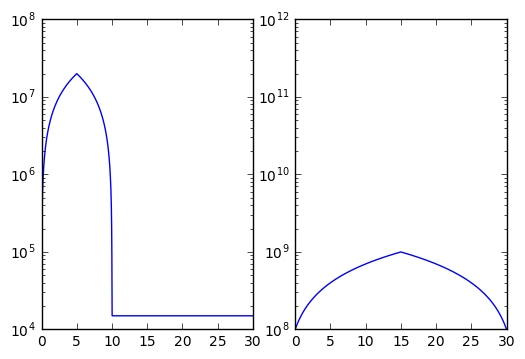

In [3]:
fig,axes = plt.subplots(1,2)
axes[0].plot(time,temperature)
axes[1].plot(time,density)
axes[0].set_ylim([1e4,1e8])
axes[1].set_ylim([1e8,1e12])
axes[1].set_yscale('log')
axes[0].set_yscale('log')

### Getting the data
We need to get three pieces of data for all of the ions:
* ionization rates as a function of temperature
* recombination rates as a function of temperature
* ionization equilibrium at the initial temperature

We will iterate through all of the ions of the given element and calculate the needed pieces. The challenge is to calculate the quantities at the correct temperatures. We will calculate the quantities over a rough temperature range and then interpolate appropriately. We'll carry out an example with iron but this should extend to any element.

First, allocate space for the ionization and recombination rates and the ionization fraction. We need a padding of $\pm1$ in our numerical method. Note that there are $Z+1$ ionization states for each element with atomic number $Z$.

When iterating over multiple loops, it will probably be best to create the ions once for a sufficient temperature range and then reuse them. The thing that seems to take the most time is the ion creation. 

In [4]:
def get_rates(element,logT0=4.,logT1=8.,dTemperature = 0.01):
    #choose appropriate temperature range
    temperature = 10.**(np.arange(logT0,logT1+dTemperature,dTemperature))
    #preallocate data
    Z = ch_tools.util.el2z(element)
    ionization_rates = np.zeros([len(temperature),Z+3])
    recombination_rates = np.zeros([len(temperature),Z+3])
    equilibrium_populations = np.zeros([len(temperature),Z+3])
    for i in range(1,Z+2):
        print('Calculating ion {}'.format(ch_tools.util.zion2name(Z,i)))
        ion = ch.ion(ch_tools.util.zion2name(Z,i),temperature=temperature)
        #ionization rate
        ion.ionizRate()
        ionization_rates[:,i] = ion.IonizRate['rate']
        #recombination rate
        ion.recombRate()
        recombination_rates[:,i] = ion.RecombRate['rate']
        #equilibrium populations
        ion.ioneqOne()
        equilibrium_populations[:,i] = ion.IoneqOne
        
    return temperature,ionization_rates,recombination_rates,equilibrium_populations

In [ ]:
def interpolate_rates(element,time,temperature,density):
    Z = ch_tools.util.el2z(element)
    ionization_rates = np.zeros([len(temperature),Z+3])
    recombination_rates = np.zeros([len(temperature),Z+3])
    nei_ionization_fractions = np.zeros([len(temperature),Z+3])
    ieq_ionization_fractions = np.zeros([len(temperature),Z+3])
    rough_temperature = np.logspace(np.log10(temperature.min()),np.log10(temperature.max()),100)
    for i in range(1,Z+2):
        print('Calculating ion {}'.format(ch_tools.util.zion2name(Z,i)))
        ion = ch.ion(ch_tools.util.zion2name(Z,i),temperature=rough_temperature,eDensity=density.mean())
        #ionization rate
        ion.ionizRate()
        iRate = splev(temperature,
                     splrep(ion.Temperature,ion.IonizRate['rate']))
        ionization_rates[:,i] = np.where(iRate<0,0,iRate)
        #recombination rate
        ion.recombRate()
        rRate = splev(temperature,
                     splrep(ion.Temperature,ion.RecombRate['rate']))
        recombination_rates[:,i] = np.where(rRate<0,0,rRate)
        #equilibrium ionization fractions
        ion.ioneqOne()
        ieq = splev(temperature,
                   splrep(ion.Temperature,ion.IoneqOne))
        ieq_ionization_fractions[:,i] = np.where(ieq<0,0,ieq)
        nei_ionization_fractions[0,i] = ieq_ionization_fractions[0,i]
        
    return ionization_rates,recombination_rates,nei_ionization_fractions,ieq_ionization_fractions

In [ ]:
element = 'fe'
ionization_rates,recombination_rates,nei_ionization_fractions,ieq_ionization_fractions = interpolate_rates(element,
                                                                                                           time,
                                                                                                           temperature,
                                                                                                           density)

### Solving the Differential Equations

Now that we have the data, it is a matter of using it in our numerical method.

In [ ]:
@numba.jit(nopython=True)
def make_ir_matrix(iRate,rRate):
    ir_matrix = np.zeros((iRate.shape[0]-2,iRate.shape[0]-2))
    for i_diag in np.arange(iRate.shape[0]-2):
        ir_matrix[i_diag,i_diag] = -(iRate[i_diag+1] + rRate[i_diag])
        if i_diag > 0:
            ir_matrix[i_diag,i_diag-1] = iRate[i_diag]
            ir_matrix[i_diag-1,i_diag] = rRate[i_diag]

    return ir_matrix

In [ ]:
@numba.jit(nopython=True)
def integrate_ionization_fraction_mat(time,density,ieq_pops,ionRate,recRate,cutoff=1e-10):
    dt = np.diff(time)
    ion_pops = np.zeros(ieq_pops.shape)
    ion_pops[0,:] = ieq_pops[0,:]
    #ion_pops = np.where(ion_pops<cutoff,0,ion_pops)
    for i in range(1,len(time)):
        #make implicit method matrix
        if i%int(len(time)/10)==0:
            print(time[i])
        ir_mat = make_ir_matrix(ionRate[i,:],recRate[i,:])
        ir_mat_old = make_ir_matrix(ionRate[i-1,:],recRate[i-1,:])
        plus_inv = 1.0 - ir_mat*dt[i-1]/2.*density[i]
        old_inv = 1.0 + ir_mat_old*dt[i-1]/2.*density[i-1]
        #invert and update
        ion_pops[i,1:-1] = np.dot(np.dot(np.linalg.inv(plus_inv),old_inv),ion_pops[i-1,1:-1])
        #normalize
        ion_pops[i,:] = ion_pops[i,:]/np.sum(ion_pops[i,:])
        #ion_pops = np.where(ion_pops<cutoff,0,ion_pops)
        
    return ion_pops

In [ ]:
@numba.jit(nopython=True)
def integrate_ionization_fraction(time,density,ionization_fraction,ionRate,recRate):
    dt = np.diff(time)
    #normalize
    ionization_fraction[0,:] = ionization_fraction[0,:]/np.sum(ionization_fraction[0,:])
    for i in range(1,len(time)):
        #dYdt_term1 = ionRate[i,:-2]*ionization_fraction[i-1,:-2]
        #dYdt_term2 = recRate[i,1:-1]*ionization_fraction[i-1,2:]
        #dYdt_term3 = ionRate[i,1:-1]*ionization_fraction[i-1,1:-1]
        #dYdt_term4 = recRate[i,:-2]*ionization_fraction[i-1,1:-1]
        #dYdt = density[i]*(dYdt_term1 + dYdt_term2 - dYdt_term3 - dYdt_term4)
        mat_ir = make_ir_matrix(ionRate[i-1,:],recRate[i-1,:])
        dYdt = density[i-1]*np.dot(mat_ir,ionization_fraction[i-1,1:-1])
        ionization_fraction[i,1:-1] = ionization_fraction[i-1,1:-1] + dt[i-1]*dYdt
        #normalize
        ionization_fraction[i,:] = ionization_fraction[i,:]/np.sum(ionization_fraction[i,:])
    
    return ionization_fraction

Try an explicit method with timestep control

In [5]:
@numba.jit(nopython=True)
def numba_lagrange_interpolator(x_data,y_data,x):
    #checks
    if len(x_data) != len(y_data):
        raise ValueError('x_data and y_data must be of equal length')
    if len(x_data) < 3:
        raise ValueError('Data must be at least length 3')
    if x>np.max(x_data) or x<np.min(x_data):
        raise ValueError('x is outside of the interpolation range.')
    
    # get the points
    if len(np.where(x==x_data)[0])>0:
        return y_data[np.where(x==x_data)[0][0]]
    else:
        i_min = np.where(x_data<x)[0][-1]
        i_max = np.where(x_data>x)[0][0]
        if i_min == 0:
            i_mid,i_max = 1,2
        else:
            i_min,i_mid = i_max-2,i_max-1
    
    x0,x1,x2 = x_data[i_min],x_data[i_mid],x_data[i_max]
    y0,y1,y2 = y_data[i_min],y_data[i_mid],y_data[i_max]
    
    # calculate Lagrange interpolation points
    term1 = (x - x1)*(x - x2)/(x0 - x1)/(x0 - x2)*y0
    term2 = (x - x0)*(x - x2)/(x1 - x0)/(x1 - x2)*y1
    term3 = (x - x0)*(x - x1)/(x2 - x0)/(x2 - x1)*y2
    
    return term1 + term2 + term3

In [6]:
@numba.jit(nopython=True)
def interpolator_wrapper(x_data,y_array_data,x,normalize=False,cutoff=0.):
    y = np.zeros(y_array_data.shape[1])
    for i in range(y_array_data.shape[1]):
        y[i] = numba_lagrange_interpolator(x_data,y_array_data[:,i],x)
    y = np.where(y<cutoff,np.zeros(len(y)),y)
    if normalize:
        y /= np.sum(y)
    return y

In [7]:
@numba.jit(nopython=True)
def solve_nei_explicit_control(t,T,n,I,R,EQ,T_data,cutoff=1e-10,eps_r=0.6,eps_d=0.1,
                               safety=0.1,safety_increase=2.,safety_decrease=10.):
        
    #initialize all parameters
    cur_time = t[0]
    cur_temperature = T[0]
    cur_density = n[0]
    cur_pops = interpolator_wrapper(T_data,EQ,T[0],cutoff=cutoff,normalize=True)
    cur_I = interpolator_wrapper(T_data,I,cur_temperature)
    cur_R = interpolator_wrapper(T_data,R,cur_temperature)
    
    #create save parameters
    time = np.zeros(t.shape)
    temperature = np.zeros(t.shape)
    density = np.zeros(t.shape)
    nei_pops = np.zeros((t.shape[0],EQ.shape[1]))
    time[0] = cur_time
    temperature[0] = cur_temperature
    density[0] = cur_density
    nei_pops[0,:] = cur_pops
    
    dt_old = t[1] - t[0]
    step = 1
    save_this_step = False
    #evolve in time
    while cur_time < t[-1]:
        dydt = cur_density*(cur_I[:-2]*cur_pops[:-2] + cur_R[1:-1]*cur_pops[2:]
                            - cur_I[1:-1]*cur_pops[1:-1] - cur_R[:-2]*cur_pops[1:-1])
        #dydt = np.where(dydt==0.0,1e-300*np.ones(len(dydt)),dydt)
        #calculate timesteps
        dt_1 = safety*eps_d/np.fabs(dydt)
        dt_2 = 0.5*(10.**eps_r - 1 + np.fabs(10.**(-eps_r) - 1.))*cur_pops[1:-1]/np.fabs(dydt)
        #dt_1 = np.where(cur_pops[1:-1]<cutoff,np.inf,dt_1)
        dt_2 = np.where(cur_pops[1:-1]<cutoff,np.inf*np.ones(len(dt_2)),dt_2)
        dt = np.min(np.stack((dt_1,dt_2)))
        dt = max(dt,dt_old/safety_decrease) #dont let timestep decrease too quickly
        dt = min(dt,safety_increase*dt_old) #dont let timestep increase too quickly
        dt_old = dt
        if cur_time + dt > t[step]:
            dt = np.fabs(t[step] - cur_time)
            save_this_step = True
        #update
        cur_time += dt
        cur_pops[1:-1] = cur_pops[1:-1] + dydt*dt
        cur_pops /= np.sum(cur_pops)
        cur_pops = np.where(cur_pops<cutoff,np.zeros(len(cur_pops)),cur_pops)
        cur_temperature = numba_lagrange_interpolator(t,T,cur_time)
        cur_density = numba_lagrange_interpolator(t,n,cur_time)
        cur_I = interpolator_wrapper(T_data,I,cur_temperature)
        cur_R = interpolator_wrapper(T_data,R,cur_temperature)
        #save
        if save_this_step:
            time[step] = cur_time
            temperature[step] = cur_temperature
            density[step] = cur_density
            nei_pops[step,:] = cur_pops
            step += 1
            save_this_step = False
        
    return nei_pops

Try solving with the matrix/implicit method

In [ ]:
nei_fractions = integrate_ionization_fraction_mat(time,
                                                  density,
                                                  ieq_ionization_fractions,
                                                  ionization_rates,
                                                  recombination_rates)

In [ ]:
#%%timeit
nei_fractions_explicit = integrate_ionization_fraction(time,
                                              density,
                                              np.array(nei_ionization_fractions,copy=True),
                                              ionization_rates,
                                              recombination_rates)

Use our explicit method with stepsize control to integrate the NEI equations.

In [8]:
temperature_data,irates,rrates,eq_pops = get_rates('fe',logT0=4,logT1=8,dTemperature=0.01)

Calculating ion fe_1
 Elvlc file missing for fe_1
Calculating ion fe_2
Calculating ion fe_3
Calculating ion fe_4
Calculating ion fe_5
Calculating ion fe_6
Calculating ion fe_7
Calculating ion fe_8
Calculating ion fe_9
Calculating ion fe_10
Calculating ion fe_11
Calculating ion fe_12
Calculating ion fe_13
Calculating ion fe_14
Calculating ion fe_15
Calculating ion fe_16
Calculating ion fe_17
Calculating ion fe_18
Calculating ion fe_19
Calculating ion fe_20
Calculating ion fe_21
Calculating ion fe_22
Calculating ion fe_23
Calculating ion fe_24
Calculating ion fe_25
Calculating ion fe_26
Calculating ion fe_27


In [9]:
nei_pops_control = solve_nei_explicit_control(time,temperature,density,irates,rrates,eq_pops,temperature_data,
                                                cutoff=1e-300)

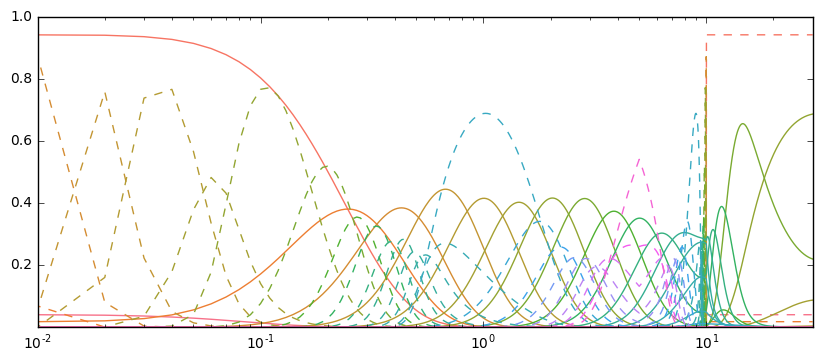

In [10]:
fig = plt.figure(figsize=(10,4))
ax = fig.gca()
z1 = 1
z2 = 27
colors = sns.color_palette('husl',n_colors=z2-z1+1)
for i,c in zip(range(z1,z2+1),colors):
    #ax.plot(time,nei_fractions[:,i],color=c,label=r'Fe {}'.format(i),linestyle='-')
    #ax.plot(time,nei_fractions_explicit[:,i],color=c,linestyle=':')
    ax.plot(time,nei_pops_control[:,i],color=c,label=r'Fe {}'.format(i),linestyle='-')
    ax.plot(time,splev(temperature,splrep(temperature_data,eq_pops[:,i])),color=c,linestyle='--')
#ax.set_yscale('log')
ax.set_ylim([1e-3,1])
ax.set_xlim([1e-2,30])
ax.set_xscale('log')
#ax.legend(ncol=6)

In [18]:
np.repeat(nei_pops_control[:,10,np.newaxis],10,axis=1)

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.62016894e-66,   3.62016894e-66,   3.62016894e-66, ...,
          3.62016894e-66,   3.62016894e-66,   3.62016894e-66],
       ..., 
       [  7.10109793e-05,   7.10109793e-05,   7.10109793e-05, ...,
          7.10109793e-05,   7.10109793e-05,   7.10109793e-05],
       [  7.09920574e-05,   7.09920574e-05,   7.09920574e-05, ...,
          7.09920574e-05,   7.09920574e-05,   7.09920574e-05],
       [  7.09732559e-05,   7.09732559e-05,   7.09732559e-05, ...,
          7.09732559e-05,   7.09732559e-05,   7.09732559e-05]])


## Comparisons with IonPopSolver Code
Now we'll make a direct comparison with the C++ `IonPopSolver` code.

Run the `IonPopSolver` code for the full range of population fractions for the sample data.

In [ ]:
executable = ['/home/wtb2/Documents/IonPopSolver/bin/IonPopSolver.run']
ips_args = ["-Z","26","-f","1","-t","27",
            "-r",'/home/wtb2/Documents/IonPopSolver/test/radiation.local.cfg.xml',
            "-I","/home/wtb2/Documents/IonPopSolver/test/Tt_nt_1.txt",
            "-O","/home/wtb2/Documents/research_notebook/FieldLineViz/nei_prototyping_ips_test.txt"
           ]

In [ ]:
subprocess.call(executable+ips_args)

Import the results

In [ ]:
ips_results = np.loadtxt('nei_prototyping_ips_test.txt')
time_ips,temperature_ips,Teff_ips,density_ips,nei_fractions_ips = ips_results[:,0],ips_results[:,1],ips_results[:,2],ips_results[:,3],ips_results[:,4:]

In [ ]:
fig,axes = plt.subplots(1,2)
axes[0].plot(time_ips,temperature_ips)
axes[0].plot(time_ips,Teff_ips,'--r')
axes[1].plot(time_ips,density_ips)

Compare this with our new controlled solver.

In [ ]:
nei_pops_c_ips = solve_nei_explicit_control(time_ips,temperature_ips,density_ips,
                                                                            irates,rrates,eq_pops,temperature_data,
                                                                    cutoff=1e-100)

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.gca()
z1 = 1
z2 = 27
colors = sns.color_palette('husl',n_colors=z2-z1+1)
for i,c in zip(range(z1,z2+1),colors):
    ax.plot(time_ips,nei_pops_c_ips[:,i],color=c,label=r'Fe {}'.format(i),linestyle='-')
    ax.plot(time_ips,nei_fractions_ips[:,i-1],color=c,linestyle='--')
    #ax.plot(t_c_ips,interp1d(temperature_data,eq_pops,axis=0)(T_c_ips)[:,i],color=c,linestyle=':')
ax.set_yscale('log')
ax.set_ylim([1e-3,0.8])
ax.set_xlim([2,30])
ax.set_xscale('log')
#ax.legend(ncol=6)

Plot ionization and recombination rates.

In [ ]:
temperature_data,iRate_data,rRate_data,eq_pops = get_rates('fe')

In [ ]:
iRate_interp = np.array([splev(temperature,splrep(temperature_data,iRate_data[:,i])) for i in range(iRate_data.shape[1])])
iRate_interp = np.where(iRate_interp<0,0,iRate_interp).T
rRate_interp = np.array([splev(temperature,splrep(temperature_data,rRate_data[:,i])) for i in range(rRate_data.shape[1])])
rRate_interp = np.where(rRate_interp<0,0,rRate_interp).T

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
z1 = 1
z2 = 27
colors = sns.color_palette('husl',n_colors=z2-z1+1)
for i,c in zip(range(z1,z2+1),colors):
    axes[0].plot(temperature_data,iRate_data[:,i],color=c,alpha=0.5)
    axes[0].plot(temperature,iRate_interp[:,i],color=c,marker='o',markersize=5,markevery=30,alpha=0.5)
    axes[1].plot(temperature_data,rRate_data[:,i],color=c,alpha=0.5,label=r'Fe {}'.format(i))
    axes[1].plot(temperature,rRate_interp[:,i],color=c,marker='o',markersize=5,markevery=30,alpha=0.5)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[0].set_ylim([1e-20,1e-6])
axes[1].set_ylim([1e-15,1e-8])
axes[0].set_xlim([1e5,3e7])
axes[1].set_xlim([1e5,3e7])
axes[1].legend(ncol=7,loc='best')

## Tests with Loop Solutions
Now we'll load an actual loop $T$ and $n$ and compute the population fractions.

In [ ]:
ih = InputHandler('/data/datadrive2/ar_viz/nessf_example/hydro_config/loop0.xml')
input_dict = ih.lookup_vars()

In [ ]:
input_dict['output_filename'] = '/home/wtb2/Documents/research_notebook/FieldLineViz/nei_prototyping_ebtel_test'

In [ ]:
oh = OutputHandler(input_dict['output_filename']+'.xml',input_dict)

In [ ]:
oh.print_to_xml()

In [ ]:
executable = ['/home/wtb2/Documents/ebtelPlusPlus/bin/ebtel++.run']
ebtel_args = ["-c","/home/wtb2/Documents/research_notebook/FieldLineViz/nei_prototyping_ebtel_test.xml"
           ]

In [ ]:
subprocess.call(executable+ebtel_args)

Import results

In [ ]:
data = np.loadtxt(input_dict['output_filename'])
loop_time = data[:,0]
loop_temperature = data[:,1]
loop_density = data[:,3]

In [ ]:
fig,axes = plt.subplots(1,2)
axes[0].plot(loop_time,loop_temperature)
#axes[0].set_xlim([0,200])
axes[1].plot(loop_time,loop_density)
#axes[1].set_xlim([0,200])

In [ ]:
plt.plot(loop_time[1:],np.diff(loop_time))
plt.yscale('log')

In [ ]:
%%timeit
nei_pops_loop = solve_nei_explicit_control(loop_time,loop_temperature,loop_density,
                                            irates,rrates,eq_pops,temperature_data,
                                           )

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.gca()
z1 = 1
z2 = 27
colors = sns.color_palette('husl',n_colors=z2-z1+1)
for i,c in zip(range(z1,z2+1),colors):
    ax.plot(loop_time,nei_pops_loop[:,i],color=c,label=r'Fe {}'.format(i))
    ax.plot(loop_time,interp1d(temperature_data,eq_pops,axis=0)(loop_temperature)[:,i],color=c,linestyle='--')
    #ax.plot(time_loop_ips,nei_pops_ips[:,i-1],color=c,linestyle='--')
#ax.set_yscale('log')
ax.set_ylim([1e-6,1])
ax.set_xlim([1300,4000])
#ax.set_xscale('log')
#ax.legend(ncol=6)

Now compare with the `IonPopSolver` code.

In [ ]:
np.savetxt('loop_test.ips.input',np.transpose([field.loops[0].time.value,
                                               field.loops[0].temperature[:,0].value,
                                               field.loops[0].density[:,0].value]),
          header=str(len(field.loops[0].time.value)),comments='',fmt='%f\t%e\t%e')

In [ ]:
executable = ['/home/wtb2/Documents/IonPopSolver/bin/IonPopSolver.run']
ips_args = ["-Z","26","-f","1","-t","27",
            "-r",'/home/wtb2/Documents/research_notebook/FieldLineViz/rad_config.xml',
            "-I","/home/wtb2/Documents/research_notebook/FieldLineViz/loop_test.ips.input",
            "-O","/home/wtb2/Documents/research_notebook/FieldLineViz/loop_test.ips.output"
           ]

In [ ]:
subprocess.call(executable+ips_args)

In [ ]:
ips__loop_results = np.loadtxt('/home/wtb2/Documents/research_notebook/FieldLineViz/loop_test.ips.output')
time_loop_ips,temperature_loop_ips,Teff_loop_ips,density_loop_ips,nei_pops_ips = ips_loop_results[:,0],ips_loop_results[:,1],ips_loop_results[:,2],ips_loop_results[:,3],ips_loop_results[:,4:]

## Read in Atomic Data from `apolloDB`

Read in the equilibrium populations from `apolloDB`.

In [ ]:
eq_pops_adb = []
temperature_data_adb = []
with open('/home/wtb2/Documents/apolloDB/balances/ips_01dex/fe.bal','r') as f:
    all_lines = f.readlines()
    for line in all_lines:
        tmp = line.strip('\n').split('\t')
        temperature_data_adb.append(tmp[0])
        eq_pops_adb.append(['0.']+tmp[1:-1]+['0.'])
eq_pops_adb = np.array(eq_pops_adb,dtype=np.longdouble)
temperature_data_adb = 10.**np.array(temperature_data_adb,dtype=np.longdouble)

Read in recombination and ionizations rates.

In [ ]:
Z = eq_pops_adb.shape[1]-3
ionization_rates_adb = np.zeros((len(temperature_data_adb),Z+3),dtype=np.longdouble)
recombination_rates_adb = np.zeros((len(temperature_data_adb),Z+3),dtype=np.longdouble)
with open('/home/wtb2/Documents/apolloDB/rates/ips_01dex/fe.rts','r') as f:
    #ionization rates
    for i in range(1,Z+1):
        f.readline()
        f.readline()
        rates_tmp = []
        for j in range(int(len(temperature_data_adb)/10)+len(temperature_data_adb)%10):
            thisline = f.readline().strip('\n')
            rates_tmp += thisline.split('\t')[:-1]
        ionization_rates_adb[:,i] = np.array(rates_tmp,dtype=np.longdouble)
        f.readline()
    #recombination rates
    for i in range(2,Z+2):
        f.readline()
        f.readline()
        rates_tmp = []
        for j in range(int(len(temperature_data_adb)/10)+len(temperature_data_adb)%10):
            thisline = f.readline().strip('\n')
            rates_tmp += thisline.split('\t')[:-1]
        recombination_rates_adb[:,i] = np.array(rates_tmp,dtype=np.longdouble)
        f.readline()

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
z1 = 1
z2 = 27
colors = sns.color_palette('husl',n_colors=z2-z1+1)
for i,c in zip(range(z1,z2+1),colors):
    axes[0].plot(temperature_data,iRate_data[:,i],color=c,alpha=0.5)
    axes[0].plot(temperature_data_adb,ionization_rates_adb[:,i],color=c,marker='o',
                 markersize=5,markevery=20,alpha=0.5,linestyle='None')
    axes[1].plot(temperature_data,rRate_data[:,i],color=c,alpha=0.5,label=r'Fe {}'.format(i))
    axes[1].plot(temperature_data_adb,recombination_rates_adb[:,i],color=c,marker='o',
                    markersize=5,markevery=20,alpha=0.5,linestyle='None')
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[0].set_ylim([1e-20,1e-6])
axes[1].set_ylim([1e-13,1e-8])
axes[0].set_xlim([1e4,1e8])
axes[1].set_xlim([1e4,1e8])
#axes[1].legend(ncol=7,loc='best')

In [ ]:
len(temperature_data_adb[150:200:17])

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
z1 = 1
z2 = 27
colors = sns.color_palette('husl',n_colors=z2-z1+1)
for i,c in zip(range(z1,z2+1),colors):
    #axes[0].plot(temperature_data,iRate_data[:,i],color=c,alpha=0.5)
    points_x = temperature_data_adb[150:200:17]
    points_y = ionization_rates_adb[150:200:17,i]
    x_interp = np.linspace(points_x[0],points_x[-1],10)
    y_interp = numba_lagrange_interpolator(points_x.astype(np.float),
                                           points_y.astype(np.float),
                                           x_interp.astype(np.float))
    axes[0].plot(points_x,points_y,color=c,marker='o',
                 markersize=5,
                 #markevery=20,
                 alpha=0.5,
                 linestyle='None')
    axes[0].plot(temperature_data_adb[150:200],ionization_rates_adb[150:200],color=c,
                 alpha=0.5,
                 linestyle='-')
    axes[0].plot(x_interp,y_interp,'--k')
    #axes[1].plot(temperature_data,rRate_data[:,i],color=c,alpha=0.5,label=r'Fe {}'.format(i))
    points_x = temperature_data_adb[150:200:10]
    points_y = recombination_rates_adb[150:200:10,i]
    axes[1].plot(points_x,points_y,color=c,marker='o',
                    markersize=5,
                    #markevery=20,
                    alpha=0.5,
                    linestyle='None')
#axes[0].set_yscale('log')
#axes[0].set_xscale('log')
#axes[1].set_yscale('log')
#axes[1].set_xscale('log')
#axes[0].set_ylim([1e-20,1e-6])
#axes[1].set_ylim([1e-13,1e-8])
#axes[0].set_xlim([1e4,1e8])
#axes[1].set_xlim([1e4,1e8])
#axes[1].legend(ncol=7,loc='best')

Let's try computing the NEI populations with this alternate set of rates.

In [ ]:
t_adb,T_adb,n_adb,nei_pops_adb = solve_nei_explicit_control(time_ips,temperature_ips,density_ips,
                                                            ionization_rates_adb,
                                                            recombination_rates_adb,
                                                            eq_pops_adb,temperature_data_adb,cutoff=1e-10,
                                                            safety_increase=1.5,safety_decrease=np.inf
                                                           )

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
#ax2 = ax.twinx()
z1 = 10
z2 = 15
colors = sns.color_palette('husl',n_colors=z2-z1+1)
for i,c in zip(range(z1,z2+1),colors):
    #ax.plot(t_c_ips,nei_pops_c_ips[:,i],color=c,linestyle=':')
    ax.plot(t_adb,nei_pops_adb[:,i],color=c,label=r'Fe {}'.format(i),linestyle='-')
    ax.plot(time_ips,nei_fractions_ips[:,i-1],color=c,linestyle='--')
    ax.plot(t_adb,interp1d(temperature_data_adb,eq_pops_adb,axis=0)(T_adb)[:,i],color=c,linestyle='-.')
#ax2.plot(t_adb,T_adb,color='k',lw=3,alpha=0.4)
#ax2.plot(time_ips,temperature_ips,color='b',lw=3,alpha=0.4)
ax.set_yscale('log')
ax.set_ylim([1e-3,1])
ax.set_xlim([1e0,30])
ax.set_xscale('log')
ax.legend(ncol=2,loc='best')

## Interpolation Tests
Test the new interpolator.

In [ ]:
temperature_data,iRate_data,rRate_data,eq_pops = get_rates('fe')

In [ ]:
temp_hi_res = np.linspace(1e5,2e6,100)
irate_hi_res = np.array([numba_lagrange_interpolator(temperature_data,iRate_data[:,5],thr) for thr in temp_hi_res])

In [ ]:
plt.plot(temperature_data,iRate_data[:,5])
plt.plot(temp_hi_res,irate_hi_res,'ko',markevery=20,markersize=5)
plt.ylim([1e-15,1e-6])
plt.xscale('log')
plt.yscale('log')